In [1]:
%cd ..

C:\Users\Brown Research\Documents\vr-exoskeleton


# preferences

In [2]:
import os
from collections import defaultdict

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
path_sim = os.path.join('data', 'Simulation')
df_pref = pd.read_csv(os.path.join(path_sim, 'preferences.csv'))
print(len(df_pref))
df_pref.head()

64


,User ID,Task,A ? B Performance,A ? B Comfort,A ? C Performance,A ? C Comfort,B ? C Performance,B ? C Comfort,A Notes,B Notes,C Notes,Comments
0,19,1,>,>,<,<,<,<,NaN,NaN,NaN,NaN
1,19,2,>,>,-,-,<,<,NaN,NaN,NaN,NaN
2,19,3,>,<,>,>,<,<,NaN,NaN,NaN,NaN
3,19,4,<,>,>,<,<,<,NaN,NaN,NaN,NaN
4,20,1,<,<,>,>,>,>,NaN,NaN,C' Didn't handle blinking well,NaN


In [4]:
user_id_set = set(df_pref['User ID'])
user_ids = sorted(list(user_id_set))
print(len(user_ids))
user_ids

16


[19, 20, 21, 22, 30, 32, 33, 34, 35, 43, 46, 48, 49, 51, 52, 53]

In [5]:
df_user = pd.read_csv(os.path.join(path_sim, 'users.csv'))
df_user = df_user[df_user['id'].isin(user_id_set)]
print(len(df_user))
df_user.head()

16


,id,seconds_per_trial,seed0,model0_0,model0_1,model0_2,seed1,model1_0,model1_1,model1_2,...,model2_1,model2_2,seed3,model3_0,model3_1,model3_2,seed4,model4_0,model4_1,model4_2
5,19,45,23637,BaselineVector,LSTM,MLP,13195,BaselineVector,LSTM,MLP,...,LSTM,MLP,45020,BaselineVector,LSTM,MLP,46142,BaselineVector,LSTM,MLP
6,20,45,12673,LSTM,BaselineVector,MLP,22080,BaselineVector,MLP,LSTM,...,LSTM,BaselineVector,8665,LSTM,BaselineVector,MLP,21436,LSTM,BaselineVector,MLP
7,21,45,1708,BaselineVector,MLP,LSTM,50816,LSTM,MLP,BaselineVector,...,LSTM,MLP,3545,BaselineVector,MLP,LSTM,18083,MLP,LSTM,BaselineVector
8,22,45,56280,MLP,LSTM,BaselineVector,14016,BaselineVector,LSTM,MLP,...,LSTM,MLP,63960,MLP,LSTM,BaselineVector,14730,LSTM,MLP,BaselineVector
16,30,45,34100,BaselineVector,MLP,LSTM,47293,MLP,LSTM,BaselineVector,...,MLP,LSTM,22996,MLP,LSTM,BaselineVector,53443,LSTM,BaselineVector,MLP


In [6]:
categories = ('Performance', 'Comfort')
category_to_index = {category: i for i, category in enumerate(categories)}

task_names = ('Linear Pursuit', 'Arc Pursuit', 'Rapid Movement', 'Rapid Avoid')
task_names_short = ('Linear', 'Arc', 'Movement', 'Avoid')

model_names = ('BaselineVector', 'LSTM', 'MLP')
model_to_index = {name: i for i, name in enumerate(model_names)}

In [7]:
category_user_task_model_points = list()
for i_category, category in enumerate(categories):
    user_task_model_points = list()
    for _, row in df_user.iterrows():
        id_ = row['id']
        task_model_points = list()
        for i_task in range(len(task_names)):
            models_user = [row[f'model{i_task:d}_{i_trial:d}'] for i_trial in range(3)]
            row_pref = df_pref[(df_pref['User ID'] == id_) & (df_pref['Task'] == i_task + 1)].iloc[0]
            model_points = [0, 0, 0]
            for compare, (i_first, i_second) in zip(['A ? B', 'A ? C', 'B ? C'], [(0, 1), (0, 2), (1, 2)]):
                value = row_pref[f'{compare} {category}']
                if value == '>':
                    model_points[model_to_index[models_user[i_first]]] += 1
                elif value == '<':
                    model_points[model_to_index[models_user[i_second]]] += 1
                elif value == '-':
                    pass
                else:
                    raise ValueError(f'Unknown comparison value: {value}')
            task_model_points.append(model_points)
        user_task_model_points.append(task_model_points)
    category_user_task_model_points.append(user_task_model_points)

category_user_task_model_points = np.array(category_user_task_model_points)
print(category_user_task_model_points.shape)
category_user_task_model_points[0, :3, :2]

(2, 16, 4, 3)


array([[[1, 0, 2],
        [1, 0, 1]],

       [[2, 1, 0],
        [1, 0, 2]],

       [[2, 0, 1],
        [2, 0, 1]]])

In [8]:
# Find incomplete or cyclic rankings.

for i_category, category in enumerate(categories):
    print(f'{category}:')
    for i_user in range(category_user_task_model_points.shape[1]):
        for i_task in range(len(task_names)):
            points = category_user_task_model_points[i_category, i_user, i_task]
            if sum(points) != 3 or 2 not in points:
                print(f'    user: {user_ids[i_user]:d}; task: {i_task+1:d}; points: {points}')

Performance:
    user: 19; task: 2; points: [1 0 1]
    user: 19; task: 4; points: [1 1 1]
    user: 32; task: 2; points: [2 0 0]
    user: 32; task: 3; points: [0 2 0]
    user: 33; task: 2; points: [2 0 0]
    user: 33; task: 3; points: [2 0 0]
    user: 34; task: 2; points: [2 0 0]
    user: 51; task: 3; points: [0 2 0]
    user: 52; task: 1; points: [1 1 0]
Comfort:
    user: 19; task: 2; points: [1 0 1]
    user: 19; task: 3; points: [1 1 1]
    user: 33; task: 2; points: [2 0 0]
    user: 33; task: 3; points: [2 0 0]
    user: 34; task: 2; points: [2 0 0]
    user: 34; task: 3; points: [2 0 0]


In [9]:
# Sum over users.

category_task_model_points = category_user_task_model_points.sum(axis=1)
for i_category, category in enumerate(categories):
    print(f'{category}:')
    for i_task, model_points in enumerate(category_task_model_points[i_category]):
        print('{:>18}: {}'.format(task_names[i_task], model_points))

Performance:
    Linear Pursuit: [28 10  9]
       Arc Pursuit: [28  3 13]
    Rapid Movement: [25 13  7]
       Rapid Avoid: [29 10  9]
Comfort:
    Linear Pursuit: [26 11 11]
       Arc Pursuit: [23  7 15]
    Rapid Movement: [23 11 12]
       Rapid Avoid: [25 11 12]


In [10]:
# Sum over tasks.

category_user_model_points = category_user_task_model_points.sum(axis=2)
for i_user, user_id in enumerate(user_ids):
    print(f'User {user_id:d}:', end='')
    for i_category, category in enumerate(categories):
        print(' {}={}'.format(category, category_user_model_points[i_category, i_user]), end='')
    print()

19: Performance=[5 1 5] Comfort=[4 1 6]
20: Performance=[7 3 2] Comfort=[7 3 2]
21: Performance=[8 1 3] Comfort=[4 2 6]
22: Performance=[6 1 5] Comfort=[6 1 5]
30: Performance=[8 4 0] Comfort=[6 5 1]
32: Performance=[5 3 2] Comfort=[2 6 4]
33: Performance=[8 2 0] Comfort=[8 1 1]
34: Performance=[8 3 0] Comfort=[8 1 1]
35: Performance=[8 2 2] Comfort=[7 0 5]
43: Performance=[8 0 4] Comfort=[6 1 5]
46: Performance=[8 3 1] Comfort=[8 2 2]
48: Performance=[4 5 3] Comfort=[4 5 3]
49: Performance=[7 1 4] Comfort=[8 1 3]
51: Performance=[6 4 1] Comfort=[4 7 1]
52: Performance=[6 2 3] Comfort=[7 3 2]
53: Performance=[8 1 3] Comfort=[8 1 3]


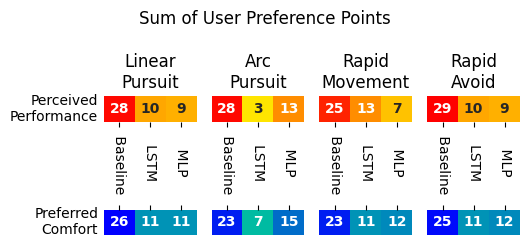

In [20]:
vmaxes = [29, 26]
cmaps = ['autumn_r', 'winter_r']

model_names_spaced = [' Baseline', '   LSTM', '    MLP']

fig, axes = plt.subplots(2, 4, figsize=(5.4, 2.45))
for i_category in range(2):
    for i_task, task_name in enumerate(task_names):
        ax = axes[i_category, i_task]
        sns.heatmap(category_task_model_points[i_category, i_task:i_task + 1],
                    vmin=0,
                    vmax=vmaxes[i_category],
                    cmap=cmaps[i_category],
                    annot=True,
                    annot_kws={'fontweight': 'bold'},
                    cbar=False,
                    xticklabels='auto' if i_category == 0 else ['' for _ in range(len(model_names))],
                    yticklabels=[],
                    ax=ax)
        if i_category == 0:
            ax.set_xticklabels(model_names_spaced, rotation=-90)
            ax.set_title('\n'.join(task_name.split(' ')))
        else:
            ax.xaxis.tick_top()

axes[0, 0].set_ylabel('Perceived\nPerformance', ha='right', va='center', rotation=0)
axes[1, 0].set_ylabel('Preferred\nComfort', ha='right', va='center', rotation=0)

plt.suptitle('Sum of User Preference Points')
plt.tight_layout()
plt.show()

### As Bars

## Scores

In [13]:
df_score = pd.read_csv(os.path.join(path_sim, 'scores.csv'))
df_score = df_score[df_score['id'].isin(user_id_set)]
assert list(df_score['id']) == user_ids
print(len(df_score))
df_score.head()

16


,id,score0_0,score0_0d,score0_1,score0_1d,score0_2,score0_2d,score0_3,score0_3d,score1_0,...,score2_3,score2_3d,score3_0,score3_0d,score3_1,score3_1d,score3_2,score3_2d,score3_3,score3_3d
1,19,2455,4051,1661,4052,672,2045,392,2051,2616,...,8,23,13,28,10,24,5,23,6,23
2,20,2680,4051,635,2042,2201,4052,848,2052,2606,...,18,28,19,30,19,28,20,30,12,28
3,21,1436,4051,1534,4052,474,2051,207,2048,1149,...,12,25,13,25,21,28,12,25,15,24
4,22,646,4051,507,2050,440,2047,1119,4052,994,...,12,26,19,29,11,25,15,27,16,27
6,30,1380,4051,1772,4052,385,2051,376,2046,1805,...,9,25,19,30,11,25,15,25,20,32


In [14]:
user_task_model_percents = list()
for _, row in df_score.iterrows():
    id_ = row['id']
    row_user = df_user[df_user['id'] == id_].iloc[0]
    task_model_percents = list()
    for i_task in range(len(task_names)):
        model_percents = [None, None, None]
        for i_trial in range(3):
            i_model = model_to_index[row_user[f'model{i_task:d}_{i_trial:d}']]
            model_percents[i_model] = row[f'score{i_task:d}_{i_trial+1:d}'] / row[f'score{i_task:d}_{i_trial+1:d}d']
        task_model_percents.append(model_percents)
    user_task_model_percents.append(task_model_percents)
user_task_model_percents = np.array(user_task_model_percents)
user_task_model_percents.shape

(16, 4, 3)

In [15]:
# Average over users.

task_model_means = np.mean(user_task_model_percents, axis=0)
task_model_means

array([[0.37814659, 0.268911  , 0.27211753],
       [0.27648384, 0.21169109, 0.29866469],
       [0.53611068, 0.46683012, 0.4226468 ],
       [0.5771178 , 0.51154458, 0.41589211]])

In [21]:
task_model_stddevs = np.std(user_task_model_percents, axis=0)
task_model_stddevs

array([[0.08454888, 0.1136087 , 0.07922165],
       [0.07077539, 0.07846992, 0.10601709],
       [0.10459184, 0.07494812, 0.07884272],
       [0.10635485, 0.1172717 , 0.07847865]])

In [16]:
# Average over tasks.

user_model_means = np.mean(user_task_model_percents, axis=1)
user_model_means

array([[0.40027916, 0.3273002 , 0.32318805],
       [0.52802261, 0.42157472, 0.4447452 ],
       [0.49334896, 0.37299287, 0.37124161],
       [0.42797469, 0.37554958, 0.36299361],
       [0.50474046, 0.33540593, 0.30619512],
       [0.39849722, 0.32478878, 0.31347042],
       [0.42947206, 0.36423731, 0.36586395],
       [0.54625699, 0.41067446, 0.40917102],
       [0.38645892, 0.29375294, 0.34047795],
       [0.50738939, 0.39504539, 0.40725766],
       [0.42758285, 0.32630231, 0.29413733],
       [0.42492276, 0.43075581, 0.4031384 ],
       [0.27095262, 0.28080499, 0.24638423],
       [0.39030811, 0.38364936, 0.32178422],
       [0.51280004, 0.43761562, 0.35917722],
       [0.42242881, 0.35545689, 0.36805852]])

In [17]:
# Extend the "RdPu" color map with black past 0.8.
if mpl.colormaps.get('RdPu8') is None:
    rdpu = mpl.colormaps['RdPu']
    
    channels = ('red', 'green', 'blue', 'alpha')
    cdict = dict()
    for channel in channels:
        cdict[channel] = list()
        for x, y0, y1 in rdpu._segmentdata[channel]:
            cdict[channel].append([0.8 * x, y0, y1])
        cdict[channel].append([1., 0., 0.] if channel != 'alpha' else [1., 1., 1.])
    
    rdpu_point8 = LinearSegmentedColormap('RdPu8', cdict)
    mpl.colormaps.register(cmap=rdpu_point8)

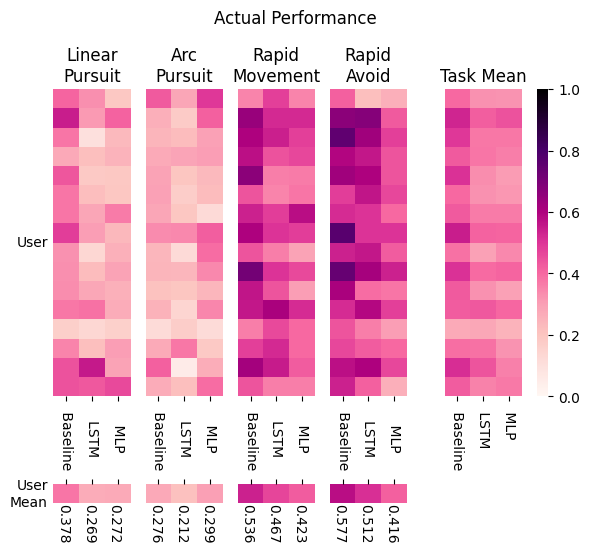

In [19]:
fig, axes = plt.subplots(
    2, 7,
    width_ratios=(*(1 for _ in range(len(task_names))), 0.1, 1, 0.15),
    height_ratios=(len(user_ids), 1),
    figsize=(6.0, 5.6)
)

vmin, vmax = 0.0, 1.0
cmap = 'RdPu8'  # 'RdPu'
for i_task, task_name in enumerate(task_names):
    ax = axes[0, i_task]
    # cbar, cbar_ax = False, None
    # if i_task == len(task_names) - 1:
    #     cbar = True
    #     cbar_ax = axes[0, -1]
    sns.heatmap(
        user_task_model_percents[:, i_task],
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        cbar=False,
        # cbar_ax=cbar_ax,
        yticklabels=[],  # user_ids if i_task == 0 else [],
        ax=ax,
    )
    ax.set_title('\n'.join(task_name.split(' ')))
    # xticklabels = [f'{model_name[:8]}' for model_name in model_names]
    ax.set_xticklabels(model_names_spaced, rotation=-90)

# Task aggregate.
sns.heatmap(
    user_model_means,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    cbar=True,
    cbar_ax=axes[0, -1],
    yticklabels=[],
    ax=axes[0, -2]
)
axes[0, -2].set_title('Task Mean')
axes[0, -2].set_xticklabels([' {}'.format(s.strip()) for s in model_names_spaced], rotation=-90)

# User aggregate.
for i_task, task_name in enumerate(task_names):
    ax = axes[1, i_task]
    sns.heatmap(
        task_model_means[i_task:i_task + 1],
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        # annot=True,
        # fmt='.2f',
        # annot_kws={},
        cbar=False,
        xticklabels=['' for _ in range(len(model_names))],
        yticklabels=[],
        ax=ax,
    )
    ax.xaxis.tick_top()
    for i_model, value in enumerate(task_model_means[i_task]):
        ax.text(i_model + 0.65, 1, f'{value:.3f}', ha='right', va='top', rotation=-90)

fig.suptitle('Actual Performance')
axes[0, 0].set_ylabel('User', ha='right', va='center', rotation=0)
axes[1, 0].set_ylabel('User\nMean', ha='right', va='center', rotation=0)

axes[0, len(task_names)].axis('off')  # https://stackoverflow.com/questions/10035446/how-can-i-make-a-blank-subplot-in-matplotlib
axes[1, len(task_names)].axis('off')
axes[1, -2].axis('off')
axes[1, -1].axis('off')
plt.tight_layout()
plt.show()

## As Boxes